# testing jax inference

In [1]:
import numpy as np
import os

In [2]:
bpath = '/home/storage/hans/photondata/code/github_separate_distance/network/tmp2/final_cdf_all_detector_weights/'

In [3]:
params = []

for i in range(0, 9):
    layer_weights = np.load(os.path.join(bpath, f'dense_{i}_weights.npy'))
    layer_bias = np.load(os.path.join(bpath, f'dense_{i}_bias.npy'))
    print(layer_weights.shape)
    print(layer_bias.shape)
    params.append((layer_weights, layer_bias))

(7, 232)
(232,)
(232, 232)
(232,)
(232, 232)
(232,)
(232, 232)
(232,)
(232, 232)
(232,)
(232, 232)
(232,)
(232, 232)
(232,)
(232, 232)
(232,)
(232, 9)
(9,)


In [4]:
print(params[0][0].shape)
print(params[0][1].shape)
print(params[-1][0].shape)
print(params[-1][1].shape)

(7, 232)
(232,)
(232, 9)
(9,)


In [5]:
import jax.numpy as jnp

In [6]:
def network(x, params=params):
    x = jnp.tanh(jnp.dot(x, params[0][0]) + params[0][1])

    # residual block 1
    y = jnp.tanh(jnp.dot(x, params[1][0]) + params[1][1])
    y = jnp.tanh(jnp.dot(y, params[2][0]) + params[2][1])
    x = jnp.tanh(jnp.dot(y, params[3][0]) + params[3][1]) + x

    # residual block 2
    y = jnp.tanh(jnp.dot(x, params[4][0]) + params[4][1])
    y = jnp.tanh(jnp.dot(y, params[5][0]) + params[5][1])
    x = jnp.tanh(jnp.dot(y, params[6][0]) + params[6][1]) + x

    # outputs
    y = jnp.tanh(jnp.dot(x, params[7][0]) + params[7][1])
    z = jnp.dot(y, params[8][0]) + params[8][1]
    return z

In [7]:
dist = 25
z = -210
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

In [8]:
def transform_dimensions(dist, t_rho, t_z, km_scale = 1000):
    x0 = dist / km_scale
    x1 = np.cos(t_rho)
    x2 = np.sin(t_rho)
    x3 = t_z / km_scale
    return [x0, x1, x2, x3]

def dir_to_xyz(zenith, azimuth):
    z = np.cos(np.deg2rad(zenith))
    x = np.sin(np.deg2rad(zenith)) * np.cos(np.deg2rad(azimuth))
    y = np.sin(np.deg2rad(zenith)) * np.sin(np.deg2rad(azimuth))
    return [z, x, y]

In [9]:
x = np.concatenate([transform_dimensions(dist, rho, z), dir_to_xyz(zenith, azimuth)])

In [10]:
print(network(x))
# compare to output from tensorflow
# 1/1 [==============================] - 0s 123ms/step
# [[ 1.4350291  1.3923147  1.3053916 -2.8261225 -1.9026213 -3.980585
#  -4.6954675 -2.7720673 -6.443706 ]]

[ 1.4350296  1.3923144  1.3053923 -2.8261218 -1.9026213 -3.9805856
 -4.695467  -2.7720673 -6.4437056]


In [46]:
%timeit network(x).block_until_ready()

954 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
import jax

@jax.jit
def network_jit(x, params=params):
    x = jnp.tanh(jnp.dot(x, params[0][0]) + params[0][1])

    # residual block 1
    y = jnp.tanh(jnp.dot(x, params[1][0]) + params[1][1])
    y = jnp.tanh(jnp.dot(y, params[2][0]) + params[2][1])
    x = jnp.tanh(jnp.dot(y, params[3][0]) + params[3][1]) + x

    # residual block 2
    y = jnp.tanh(jnp.dot(x, params[4][0]) + params[4][1])
    y = jnp.tanh(jnp.dot(y, params[5][0]) + params[5][1])
    x = jnp.tanh(jnp.dot(y, params[6][0]) + params[6][1]) + x

    # outputs
    y = jnp.tanh(jnp.dot(x, params[7][0]) + params[7][1])
    z = jnp.dot(y, params[8][0]) + params[8][1]
    return z

In [13]:
print(network_jit(x))

[ 1.4350296  1.3923144  1.3053923 -2.8261218 -1.9026213 -3.9805856
 -4.695467  -2.7720673 -6.4437056]


In [47]:
%timeit network_jit(x).block_until_ready()

53.1 µs ± 2.05 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [15]:
@jax.jit
def network_jit_component(x, params=params, idx=0):
    x = jnp.tanh(jnp.dot(x, params[0][0]) + params[0][1])

    # residual block 1
    y = jnp.tanh(jnp.dot(x, params[1][0]) + params[1][1])
    y = jnp.tanh(jnp.dot(y, params[2][0]) + params[2][1])
    x = jnp.tanh(jnp.dot(y, params[3][0]) + params[3][1]) + x

    # residual block 2
    y = jnp.tanh(jnp.dot(x, params[4][0]) + params[4][1])
    y = jnp.tanh(jnp.dot(y, params[5][0]) + params[5][1])
    x = jnp.tanh(jnp.dot(y, params[6][0]) + params[6][1]) + x

    # outputs
    y = jnp.tanh(jnp.dot(x, params[7][0]) + params[7][1])
    z = jnp.dot(y, params[8][0]) + params[8][1]
    return z[idx]

In [45]:
print(jax.value_and_grad(network_jit_component)(x))

(Array(1.4350296, dtype=float32), Array([ 57.297993  ,  -0.3703457 ,  -0.06091708, -36.54707   ,
         2.0929332 ,  -0.48832357,   0.50331485], dtype=float32))


In [43]:
#%timeit jax.value_and_grad(network_jit_component)(x)
%timeit jax.grad(network_jit_component, argnums=0)(x).block_until_ready()

1.26 ms ± 5.17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
# make a plot

In [19]:
import matplotlib.pyplot as plt
import pickle

In [27]:
#zenith = 20.095032646337103
#azimuth = 59.0791043542297

zenith = 95.0
azimuth = 40.80309989368208

#zenith = 95.0
#azimuth = 139.19690010631788

#zenith = 159.9049673536629
#azimuth = 120.92089564577029

infile = f'/home/storage/hans/photondata/fullazisupport/pickle/phototable_infinitemuon_zenith{zenith}_azimuth{azimuth}.pkl'
table, bin_info = load_table_from_pickle(infile)

In [32]:
from typing import Dict, List, Any
import copy

def load_table_from_pickle(infile: str) -> List[Any]:
    table = pickle.load(open(infile, "rb"))
    bin_info = dict()
    bin_info['dist'] = {'c': table['bin_centers'][0],
            'e': table['bin_edges'][0],
            'w': table['bin_widths'][0]}

    bin_info['rho'] = {'c': table['bin_centers'][1],
            'e': table['bin_edges'][1],
            'w': table['bin_widths'][1]}

    bin_info['z'] = {'c': table['bin_centers'][2],
            'e': table['bin_edges'][2],
            'w': table['bin_widths'][2]}

    bin_info['dt'] = {'c': table['bin_centers'][3],
            'e': table['bin_edges'][3],
            'w': table['bin_widths'][3]}

    return table, bin_info

def get_bin_idx(val: float, bins: np.ndarray) -> int:
    assert np.logical_and(val > bins[0], val < bins[-1]), f'value {val} not within bounds [{bins[0]}, {bins[-1]}]'
    return np.digitize(val, bins, right=False)-1

def adjust_plot_1d(fig, ax, plot_args=None):
    if not plot_args:
        plot_args = {}

    for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(1.5)
          ax.spines[axis].set_color('0.0')

    y_scale_in_log = plot_args.get('y_axis_in_log', False)
    if(y_scale_in_log):
        ax.set_yscale('log')

    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel(plot_args.get('ylabel', 'pdf'), fontsize=20)
    ax.set_xlabel(plot_args.get('xlabel', 'var 1'), fontsize=20)
    ax.set_ylim(plot_args.get('ylim', [0, 1]))
    ax.set_xlim(plot_args.get('xlim', [0, 1]))
    ax.legend()

def get_effective_binomial_photons(dist, rho, z, table, bin_info, error_scale=1, as_float=False):
    i = get_bin_idx(dist, bin_info['dist']['e'])
    j = get_bin_idx(rho, bin_info['rho']['e'])
    k = get_bin_idx(z, bin_info['z']['e'])

    prob_vals = copy.copy(table['values'][i, j, k, :])
    prob_err = copy.copy(table['weights'][i, j, k, :])

    if not as_float:
        total_statistical_power = int(np.sum(prob_vals) ** 2 / np.sum(prob_err)) / error_scale
    else:
        total_statistical_power = np.sum(prob_vals) ** 2 / np.sum(prob_err) / error_scale

    fracs_in_each_bin = prob_vals / np.sum(prob_vals)
    n_photons_in_each_bin = fracs_in_each_bin * total_statistical_power

    if not as_float:
        return np.rint(n_photons_in_each_bin).astype(int), int(np.rint(total_statistical_power))
    else:
        return n_photons_in_each_bin, total_statistical_power

def get_prob_vals(dist, rho, z, table, bin_info):
    i = get_bin_idx(dist, bin_info['dist']['e'])
    j = get_bin_idx(rho, bin_info['rho']['e'])
    k = get_bin_idx(z, bin_info['z']['e'])

    prob_vals = copy.copy(table['values'][i, j, k, :])
    return copy.copy(prob_vals)


def get_nearest_center_value(dist, z, rho):
    i = get_bin_idx(dist, bin_info['dist']['c'])
    j = get_bin_idx(z, bin_info['z']['c'])
    k = get_bin_idx(rho, bin_info['rho']['c'])

    return bin_info['dist']['c'][i], bin_info['z']['c'][j], bin_info['rho']['c'][k]

In [36]:
import jax
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions


def make_dt_plot_w_pdf(dist, rho, z, zenith, azimuth, table, bin_info, scale=10, logscale=False):

    x = np.concatenate([transform_dimensions(dist, rho, z), dir_to_xyz(zenith, azimuth)])
    y_pred = network_jit(x)
    a = 1+20*jax.nn.sigmoid(y_pred[3:6]) + 1.e-30
    b = 2.0*jax.nn.sigmoid(y_pred[6:9])
    logits = y_pred[0:3]
    
    pars = (logits, a, b)

    i = get_bin_idx(dist, bin_info['dist']['e'])
    j = get_bin_idx(rho, bin_info['rho']['e'])
    k = get_bin_idx(z, bin_info['z']['e'])

    prob_vals = copy.copy(table['values'][i, j, k, :])
    prob_err = copy.copy(np.sqrt(table['weights'][i, j, k, :]))

    tot_prob = np.sum(prob_vals)
    prob_vals /= tot_prob
    prob_vals /= bin_info['dt']['w']

    prob_err /= tot_prob
    prob_err /= bin_info['dt']['w']

    fig, ax = plt.subplots()
    ax.hist(bin_info['dt']['c'], bins=bin_info['dt']['e'], weights=prob_vals, histtype='step', lw=1,
            label=f"(d={dist:.1f}m, $\\rho$ ={rho:.2f} rad, z={z:.0f}m)", color='gray')
    ax.errorbar(bin_info['dt']['c'], prob_vals, yerr = prob_err, lw=0, elinewidth=2,color='k', zorder=100)

    xvals = np.linspace(-50, scale*dist, 1000)
    xv = xvals

    logits, gamma_a, gamma_b = pars
    gm = tfd.MixtureSameFamily(
          mixture_distribution=tfd.Categorical(
              logits=logits
              ),
          components_distribution=tfd.Gamma(
            concentration=gamma_a,       # One for each component.
            rate = gamma_b,
            force_probs_to_zero_outside_support=True
              )
    )

    yvals = gm.prob(xv)
    plt.plot(xvals, yvals, 'r-', zorder=10, linewidth=2, label='3-comp Gamma')

    plot_args = {'xlim':[-2, scale*dist],
                 'ylim':[0.0, 1.2 * np.amax([np.amax(prob_vals), np.amax(yvals)])],
                 'xlabel':'dt [ns]',
                 'ylabel':'pdf'}


    w = jax.nn.softmax(logits)
    for i,c in zip(range(3), ['purple', 'plum', 'pink']):
        tw = w[i]
        tg = tfd.Gamma(concentration=gamma_a[i], rate = gamma_b[i], force_probs_to_zero_outside_support=True)    
        yvals = tw * tg.prob(xv)
        plt.plot(xvals, yvals, color=c,linestyle='solid', zorder=8, linewidth=1.5, label=f'Gamma {i}')

    adjust_plot_1d(fig, ax, plot_args=plot_args)

    ax.set_title(f"infinite $\mu$ ($\Theta_s$={zenith:.0f}deg, $\Phi_s$={azimuth:.0f}deg)")
    if logscale:
        plt.yscale('log')
        plt.ylim(ymin=1.e-5)

    plt.tight_layout()
    plt.show()

In [37]:
plot_dist = 25.0
plot_z = -210.0
plot_rho = -1.0
dist, z, rho = get_nearest_center_value(plot_dist, plot_z, plot_rho)

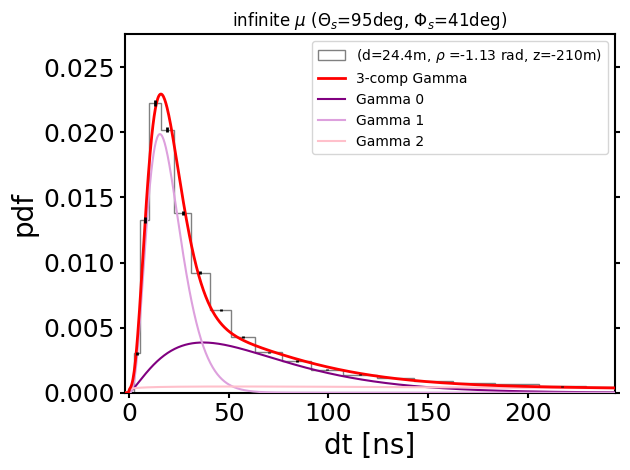

In [39]:
make_dt_plot_w_pdf(dist, rho, z, zenith, azimuth, table, bin_info)